## Data Loading and Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import IsolationForest


### Load the Datasets

In [2]:
# Load Kickstarter dataset
Crowdfunding_df=pd.read_csv("../data/kickstarter_projects.csv")

# Check basic info
print("Crowdfunding_df :")
print(Crowdfunding_df.shape)
print(Crowdfunding_df.info())

Crowdfunding_df :
(374853, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374853 entries, 0 to 374852
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ID           374853 non-null  int64 
 1   Name         374853 non-null  object
 2   Category     374853 non-null  object
 3   Subcategory  374853 non-null  object
 4   Country      374853 non-null  object
 5   Launched     374853 non-null  object
 6   Deadline     374853 non-null  object
 7   Goal         374853 non-null  int64 
 8   Pledged      374853 non-null  int64 
 9   Backers      374853 non-null  int64 
 10  State        374853 non-null  object
dtypes: int64(4), object(7)
memory usage: 31.5+ MB
None


## Data Preprocessing

### Initial Inspection

In [3]:
# Preview sample
print("Crowdfunding_df Sample:")
display(Crowdfunding_df.head())


# Check missing values percentage
print("Missing Values in Crowdfunding_df:")
missing_funding = Crowdfunding_df.isnull().mean() * 100
display(missing_funding[missing_funding > 0].sort_values(ascending=False))


# Check duplicates
print(f"\nDuplicates in Crowdfunding_df: {Crowdfunding_df.duplicated().sum()}")

# Check data types
print("\n Data Types in Crowdfunding_df:")
display(Crowdfunding_df.dtypes.value_counts())




Crowdfunding_df Sample:


,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed


Missing Values in Crowdfunding_df:


Series([], dtype: float64)


Duplicates in Crowdfunding_df: 0

 Data Types in Crowdfunding_df:


object    7
int64     4
Name: count, dtype: int64

### Ensure Datatype Consistency

In [4]:
print("CrowdFunding Data Types:\n", Crowdfunding_df.dtypes)

CrowdFunding Data Types:
 ID              int64
Name           object
Category       object
Subcategory    object
Country        object
Launched       object
Deadline       object
Goal            int64
Pledged         int64
Backers         int64
State          object
dtype: object


### Type Conversions

In [5]:
# Step 1: Convert date-like columns to datetime first

Crowdfunding_df["Deadline"] = pd.to_datetime(
    Crowdfunding_df["Deadline"].astype(str), errors='coerce'
)
Crowdfunding_df["Launched"] = pd.to_datetime(Crowdfunding_df["Launched"], errors='coerce')

# Step 2: Convert money/count columns to numeric
for col in ["Goal", "Pledged", "Backers"]:
    if col in Crowdfunding_df.columns:
        Crowdfunding_df[col] = pd.to_numeric(Crowdfunding_df[col], errors='coerce')

# Step 3: Convert remaining object columns to category
for col in Crowdfunding_df.select_dtypes(include='object').columns:
    Crowdfunding_df[col] = Crowdfunding_df[col].astype('category')

print("After type conversions:")
print(Crowdfunding_df.dtypes)


After type conversions:
ID                      int64
Name                 category
Category             category
Subcategory          category
Country              category
Launched       datetime64[ns]
Deadline       datetime64[ns]
Goal                    int64
Pledged                 int64
Backers                 int64
State                category
dtype: object


## Feature Engineering

### Feature Creation

In [6]:


# Duration in days
Crowdfunding_df["duration_days"] = (
    Crowdfunding_df["Deadline"] - Crowdfunding_df["Launched"]
).dt.total_seconds() / 86400

# Calendar features
Crowdfunding_df["launch_month"]  = Crowdfunding_df["Launched"].dt.month
Crowdfunding_df["launch_dow"]    = Crowdfunding_df["Launched"].dt.dayofweek
Crowdfunding_df["launch_year"]   = Crowdfunding_df["Launched"].dt.year

# Financial ratios
Crowdfunding_df["pledge_goal_ratio"] = Crowdfunding_df["Pledged"] / Crowdfunding_df["Goal"]
Crowdfunding_df["avg_pledge_per_backer"] = Crowdfunding_df.apply(
    lambda row: row["Pledged"] / row["Backers"] if row["Backers"] > 0 else 0, axis=1
)
# log(Goal+1)
Crowdfunding_df["log_goal"] = np.log1p(Crowdfunding_df["Goal"])  

# Binary flags
Crowdfunding_df["has_backers"] = (Crowdfunding_df["Backers"] > 0).astype(int)
Crowdfunding_df["zero_pledge"] = (Crowdfunding_df["Pledged"] == 0).astype(int)

# Quick check of new features
print("New features created:")
print([col for col in Crowdfunding_df.columns if col not in 
       ["ID","Name","Category","Subcategory","Country","Launched","Deadline","Goal","Pledged","Backers","State"]])

Crowdfunding_df.head()


New features created:
['duration_days', 'launch_month', 'launch_dow', 'launch_year', 'pledge_goal_ratio', 'avg_pledge_per_backer', 'log_goal', 'has_backers', 'zero_pledge']


,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,State,duration_days,launch_month,launch_dow,launch_year,pledge_goal_ratio,avg_pledge_per_backer,log_goal,has_backers,zero_pledge
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,United States,2009-04-21 21:02:48,2009-05-31,1000,625,30,Failed,39.123056,4,1,2009,0.625000,20.833333,6.908755,1,0
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Film & Video,Shorts,United States,2009-04-23 00:07:53,2009-07-20,80000,22,3,Failed,87.994525,4,3,2009,0.000275,7.333333,11.289794,1,0
2,1703704063,drawing for dollars,Art,Illustration,United States,2009-04-24 21:52:03,2009-05-03,20,35,3,Successful,8.088854,4,4,2009,1.750000,11.666667,3.044522,1,0
3,727286,Offline Wikipedia iPhone app,Technology,Software,United States,2009-04-25 17:36:21,2009-07-14,99,145,25,Successful,79.266424,4,5,2009,1.464646,5.800000,4.605170,1,0
4,1622952265,Pantshirts,Fashion,Fashion,United States,2009-04-27 14:10:39,2009-05-26,1900,387,10,Failed,28.409271,4,0,2009,0.203684,38.700000,7.550135,1,0


### Early‑Stage Goal Ambition

In [7]:
if "Goal" in Crowdfunding_df.columns:
    q = Crowdfunding_df["Goal"].quantile([0.33, 0.66])
    Crowdfunding_df["goal_bucket"] = pd.cut(
        Crowdfunding_df["Goal"],
        bins=[-np.inf, q.loc[0.33], q.loc[0.66], np.inf],
        labels=["low", "mid", "high"],
        include_lowest=True
    ).astype("category")

In [8]:
# Goal deciles , bucket code
Crowdfunding_df["goal_decile"] = pd.qcut(
    Crowdfunding_df["Goal"], q=10, labels=False, duplicates="drop"
).astype("int64")

Crowdfunding_df["goal_bucket_code"] = Crowdfunding_df["goal_bucket"].cat.codes.astype("int16")


### Early‑Stage Rarity / Frequency

In [9]:
# Category/Subcategory/Country frequency
for col in ["Category", "Subcategory", "Country"]:
    if col in Crowdfunding_df.columns:
        freq = Crowdfunding_df[col].value_counts(normalize=True)
        Crowdfunding_df[f"{col.lower()}_freq"] = Crowdfunding_df[col].map(freq).astype(float)

# Quick peek
Crowdfunding_df[["category_freq","subcategory_freq","country_freq"]].head()


,category_freq,subcategory_freq,country_freq
0,0.060856,0.022820,0.780621
1,0.167250,0.032965,0.780621
2,0.075099,0.008470,0.780621
3,0.086866,0.008126,0.780621
4,0.060856,0.022820,0.780621


### Early‑Stage Seasonality

In [10]:
# Launch quarter
Crowdfunding_df["launch_quarter"] = Crowdfunding_df["Launched"].dt.quarter.astype("int32")
Crowdfunding_df[["launch_month","launch_quarter"]].head()


,launch_month,launch_quarter
0,4,2
1,4,2
2,4,2
3,4,2
4,4,2


### Early‑Stage Lightweight Title/Text Cues

In [11]:
# Name length & style features
name_str = Crowdfunding_df["Name"].astype(str)

Crowdfunding_df["name_len_chars"] = name_str.str.len().astype("int32")
Crowdfunding_df["name_len_words"] = name_str.str.split().apply(len).astype("int32")

upper_counts = name_str.str.count(r"[A-Z]")
Crowdfunding_df["name_upper_ratio"] = (
    upper_counts / Crowdfunding_df["name_len_chars"].replace(0, np.nan)
).fillna(0).astype(float)

Crowdfunding_df["name_punct_count"] = name_str.str.count(r"[^\w\s]").astype("int32")

Crowdfunding_df[["name_len_chars","name_len_words","name_upper_ratio","name_punct_count"]].head()


,name_len_chars,name_len_words,name_upper_ratio,name_punct_count
0,59,10,0.169492,6
1,30,4,0.900000,0
2,19,3,0.000000,0
3,28,4,0.107143,0
4,10,1,0.100000,0


### List added columns  and check missing

In [12]:
extra_cols = [
    "goal_bucket","goal_bucket_code","goal_decile",
    "category_freq","subcategory_freq","country_freq",
    "launch_quarter",
    "name_len_chars","name_len_words","name_upper_ratio","name_punct_count"
]
present = [c for c in extra_cols if c in Crowdfunding_df.columns]
print("Extra early‑stage features added:", present)

na_extra = Crowdfunding_df[present].isna().sum()
print("\nMissing values in extra features:")
print(na_extra[na_extra > 0].sort_values(ascending=False))


Extra early‑stage features added: ['goal_bucket', 'goal_bucket_code', 'goal_decile', 'category_freq', 'subcategory_freq', 'country_freq', 'launch_quarter', 'name_len_chars', 'name_len_words', 'name_upper_ratio', 'name_punct_count']

Missing values in extra features:
Series([], dtype: int64)


### Basic validity cleanup

In [13]:

initial_rows = len(Crowdfunding_df)

# 1. Remove missing date values
Crowdfunding_df = Crowdfunding_df[
    Crowdfunding_df["Launched"].notna() & Crowdfunding_df["Deadline"].notna()
]

# 2. Remove invalid goals
Crowdfunding_df = Crowdfunding_df[Crowdfunding_df["Goal"] > 0]

# 3. Remove unrealistic durations (keep between 1–90 days)
Crowdfunding_df = Crowdfunding_df[
    (Crowdfunding_df["duration_days"] >= 1) & (Crowdfunding_df["duration_days"] <= 90)
]

# Track rows removed
removed_rows = initial_rows - len(Crowdfunding_df)
print(f"Rows removed by basic filters: {removed_rows}")
print(f"Shape after cleanup: {Crowdfunding_df.shape}")


Rows removed by basic filters: 594
Shape after cleanup: (374259, 31)


### Handle missing values after feature creation

In [14]:

# Check missing values again
missing_after_features = Crowdfunding_df.isnull().sum()
print("Missing values after feature creation:\n", missing_after_features[missing_after_features > 0])



Missing values after feature creation:
 Series([], dtype: int64)


In [15]:
# Fill NaN for pledge_goal_ratio with 0
Crowdfunding_df["pledge_goal_ratio"] = Crowdfunding_df["pledge_goal_ratio"].fillna(0)

# double-check no missing values remain
final_missing = Crowdfunding_df.isnull().sum()
print("Remaining missing values:\n", final_missing[final_missing > 0])


Remaining missing values:
 Series([], dtype: int64)


### Separate Numerical and Categorical Columns

In [16]:
# Separate columns by type for Crowdfunding_df
cf_num_cols = Crowdfunding_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cf_cat_cols = [col for col in Crowdfunding_df.select_dtypes(include='category').columns if col != "Name"]

print(f"Numeric columns in Crowdfunding_df: {len(cf_num_cols)}")
print(f"Categorical columns in Crowdfunding_df: {len(cf_cat_cols)}")

Numeric columns in Crowdfunding_df: 15
Categorical columns in Crowdfunding_df: 5


###  Outlier Detection 

In [17]:

outlier_counts = {}

for col in cf_num_cols:
    Q1 = Crowdfunding_df[col].quantile(0.25)
    Q3 = Crowdfunding_df[col].quantile(0.75)
    IQR = Q3 - Q1
    low  = Q1 - 3 * IQR
    high = Q3 + 3 * IQR
    mask = (Crowdfunding_df[col] < low) | (Crowdfunding_df[col] > high)
    outlier_counts[col] = int(mask.sum())

print("Outlier counts :")
pd.Series(outlier_counts).sort_values(ascending=False)


Outlier counts :


country_freq             82206
zero_pledge              51696
has_backers              51690
duration_days            42281
Pledged                  32490
Backers                  28526
Goal                     26462
name_upper_ratio         23702
avg_pledge_per_backer    11100
pledge_goal_ratio        10683
log_goal                   663
ID                           0
goal_decile                  0
subcategory_freq             0
category_freq                0
dtype: int64

### Encoding Categoricals Columns

In [18]:
print(f"Encoding {len(cf_cat_cols)} categorical columns: {list(cf_cat_cols)}")

# Convert categories to numeric codes
for col in cf_cat_cols:
    Crowdfunding_df[col] = Crowdfunding_df[col].cat.codes

# Check data types after encoding
print("\nData types after encoding:")
print(Crowdfunding_df.dtypes)


Encoding 5 categorical columns: ['Category', 'Subcategory', 'Country', 'State', 'goal_bucket']

Data types after encoding:
ID                                int64
Name                           category
Category                           int8
Subcategory                       int16
Country                            int8
Launched                 datetime64[ns]
Deadline                 datetime64[ns]
Goal                              int64
Pledged                           int64
Backers                           int64
State                              int8
duration_days                   float64
launch_month                      int32
launch_dow                        int32
launch_year                       int32
pledge_goal_ratio               float64
avg_pledge_per_backer           float64
log_goal                        float64
has_backers                       int64
zero_pledge                       int64
goal_bucket                        int8
goal_decile                       int

## Anomaly Detection

### Select features for anomaly detection

In [19]:
# Early-stage, numeric-friendly features only (no labels, no raw text)
feature_candidates = [
    # core monetary / temporal
    "Goal", "duration_days",
    # ratios / engineered
    "pledge_goal_ratio", "avg_pledge_per_backer", "log_goal",
    # calendar
    "launch_month", "launch_dow", "launch_year", "launch_quarter",
    # goal ambition
    "goal_bucket_code", "goal_decile",
    # rarity / frequency
    "category_freq", "subcategory_freq", "country_freq",
    # lightweight title cues
    "name_len_chars", "name_len_words", "name_upper_ratio", "name_punct_count",
    # simple binary signals
    "has_backers", "zero_pledge"
]

# Keep only those that exist in your DF
feature_cols = [c for c in feature_candidates if c in Crowdfunding_df.columns]

print("Selected features for anomaly detection (count):", len(feature_cols))
print(feature_cols)

# Build numeric-only matrix (safety: coerce & fill)
X = Crowdfunding_df[feature_cols].apply(pd.to_numeric, errors="coerce")

# Minimal NA handling for modeling (you already cleaned most in Phase 2)
na_before = int(X.isna().sum().sum())
if na_before > 0:
    X = X.fillna(0.0)
    print(f"Filled {na_before} missing values in X with 0.0 for anomaly modeling.")
else:
    print("No missing values in X.")
    
print("X shape:", X.shape)


Selected features for anomaly detection (count): 20
['Goal', 'duration_days', 'pledge_goal_ratio', 'avg_pledge_per_backer', 'log_goal', 'launch_month', 'launch_dow', 'launch_year', 'launch_quarter', 'goal_bucket_code', 'goal_decile', 'category_freq', 'subcategory_freq', 'country_freq', 'name_len_chars', 'name_len_words', 'name_upper_ratio', 'name_punct_count', 'has_backers', 'zero_pledge']
No missing values in X.
X shape: (374259, 20)


###  Isolation Forest (primary anomaly detector) → scores + flags

In [20]:


# Set the target anomaly rate; tune between 0.01–0.05 depending on strictness
CONTAMINATION = 0.03  # 3% flagged by default

iforest = IsolationForest(
    n_estimators=300,
    contamination=CONTAMINATION,
    random_state=42,
    n_jobs=-1
)

iforest.fit(X)

# decision_function: >0 = inlier, <0 = outlier. We'll invert & normalize to [0,1]
decision = iforest.decision_function(X)  # higher = more normal
raw_score = -decision                     # higher = more anomalous
# Normalize to [0,1]
score_min, score_max = raw_score.min(), raw_score.max()
anomaly_score = (raw_score - score_min) / (score_max - score_min + 1e-9)

# Binary flags from model prediction: -1 = outlier, 1 = inlier
labels = (iforest.predict(X) == -1).astype(int)

# Attach to the dataframe
Crowdfunding_df["anomaly_score_iforest"] = anomaly_score
Crowdfunding_df["is_fraud"] = labels

# Summary
flag_count = int(labels.sum())
flag_rate = flag_count / len(labels) if len(labels) else 0
print(f"IsolationForest flagged: {flag_count} campaigns ({flag_rate:.2%})")


IsolationForest flagged: 11228 campaigns (3.00%)


### Inspect top anomalies 

In [21]:
# Choose a few columns to display for inspection (only those that exist)
inspect_cols = [c for c in [
    "ID","Name","Category","Subcategory","Country","State",
    "Goal","duration_days","pledge_goal_ratio","avg_pledge_per_backer",
    "launch_month","launch_dow","launch_year","goal_bucket_code","goal_decile",
    "category_freq","subcategory_freq","country_freq",
    "name_len_chars","name_len_words","name_upper_ratio","name_punct_count",
    "anomaly_score_iforest","is_fraud"
] if c in Crowdfunding_df.columns]

topN = 15
print(f"Top {topN} most anomalous campaigns:")
display(
    Crowdfunding_df.sort_values("anomaly_score_iforest", ascending=False)
                   .head(topN)[inspect_cols]
)


Top 15 most anomalous campaigns:


,ID,Name,Category,Subcategory,Country,State,Goal,duration_days,pledge_goal_ratio,avg_pledge_per_backer,...,goal_decile,category_freq,subcategory_freq,country_freq,name_len_chars,name_len_words,name_upper_ratio,name_punct_count,anomaly_score_iforest,is_fraud
291983,624205962,J’ESPIONNE,6,139,20,1,1973113,59.344306,0.000,0.0,...,9,0.167250,0.002708,0.089825,10,1,0.900000,1,1.000000,1
82042,1883323461,SUSAN B. ANTHONY &ELIZABETH CADY STANTON FEATU...,6,93,21,1,21474836,44.481273,0.000,0.0,...,9,0.167250,0.013835,0.780621,60,9,0.833333,2,0.987043,1
91893,626956893,"""UNBELIEVABLE""",6,93,21,1,5000000,56.237998,0.000,0.0,...,9,0.167250,0.013835,0.780621,14,1,0.857143,2,0.982313,1
163907,1815288309,The Book on Comedy 10 GABAGILLTRILLBILLIOPLEXI...,1,26,21,1,100000000,59.105671,0.000,0.0,...,9,0.028862,0.013328,0.780621,60,6,0.483333,12,0.974966,1
210082,1966854130,SHADES,6,40,21,1,5000000,29.244745,0.000,0.0,...,9,0.167250,0.005810,0.780621,6,1,1.000000,0,0.974745,1
82979,1697845154,IMAGAZINE.GB.COM,9,77,20,1,384019,59.974051,0.000,0.0,...,9,0.012682,0.004660,0.089825,16,1,0.875000,2,0.974733,1
211922,915167919,THE STORY FROM A GIRL CALLED RAI,6,40,20,1,1050573,6.865475,0.000,0.0,...,9,0.167250,0.005810,0.089825,32,7,0.812500,0,0.963360,1
281728,1272523795,RISE,6,139,21,1,1500000,30.284190,0.000,0.0,...,9,0.167250,0.002708,0.780621,4,1,1.000000,0,0.959537,1
228873,891996513,PVG,4,113,21,1,1972000,59.363924,0.000,0.0,...,9,0.080205,0.059517,0.780621,3,1,1.000000,0,0.952180,1
22610,2059303923,REGIONRAT,6,93,21,1,400000,89.367523,0.000,0.0,...,9,0.167250,0.013835,0.780621,9,1,1.000000,0,0.950702,1


### Label the Fraud

In [22]:

Crowdfunding_df["fraud_label"] = np.where(Crowdfunding_df["is_fraud"] == 1,
                                          "Fraud Suspected", "Normal")

print("Label counts:")
print(Crowdfunding_df["fraud_label"].value_counts(dropna=False))

Label counts:
fraud_label
Normal             363031
Fraud Suspected     11228
Name: count, dtype: int64


### Flag rate overall

In [23]:

flag_rate = Crowdfunding_df["is_fraud"].mean()
print(f"Overall flag rate: {flag_rate:.2%}")

# Flag rate by a few key groupings
def show_flag_rates(group_col, top_n=10):
    if group_col in Crowdfunding_df.columns:
        tmp = (Crowdfunding_df
               .groupby(group_col)["is_fraud"]
               .mean()
               .sort_values(ascending=False))
        print(f"\nFlag rate by {group_col} (top {top_n}):")
        display(tmp.head(top_n))

for col in ["Category", "Country", "goal_decile"]:
    show_flag_rates(col)

# Score distribution
print("\nAnomaly score summary:")
display(Crowdfunding_df["anomaly_score_iforest"].describe(percentiles=[.5,.9,.95,.99]))


Overall flag rate: 3.00%

Flag rate by Category (top 10):


Category
9     0.061367
6     0.054762
13    0.037452
2     0.033273
7     0.031321
4     0.027457
3     0.027365
14    0.027099
11    0.026590
5     0.025352
Name: is_fraud, dtype: float64


Flag rate by Country (top 10):


Country
19    0.121053
12    0.115363
9     0.107714
17    0.095824
5     0.090197
13    0.082985
11    0.080645
2     0.079417
8     0.078915
6     0.075042
Name: is_fraud, dtype: float64


Flag rate by goal_decile (top 10):


goal_decile
9    0.123514
0    0.063957
8    0.024517
1    0.017021
7    0.016012
6    0.013432
2    0.012330
3    0.010210
5    0.009901
4    0.008097
Name: is_fraud, dtype: float64


Anomaly score summary:


count    374259.000000
mean          0.284383
std           0.140851
min           0.000000
50%           0.258355
90%           0.486873
95%           0.553444
99%           0.674263
max           1.000000
Name: anomaly_score_iforest, dtype: float64

## EDA Visualizations

### Outlier focus (boxplots for most skewed columns)

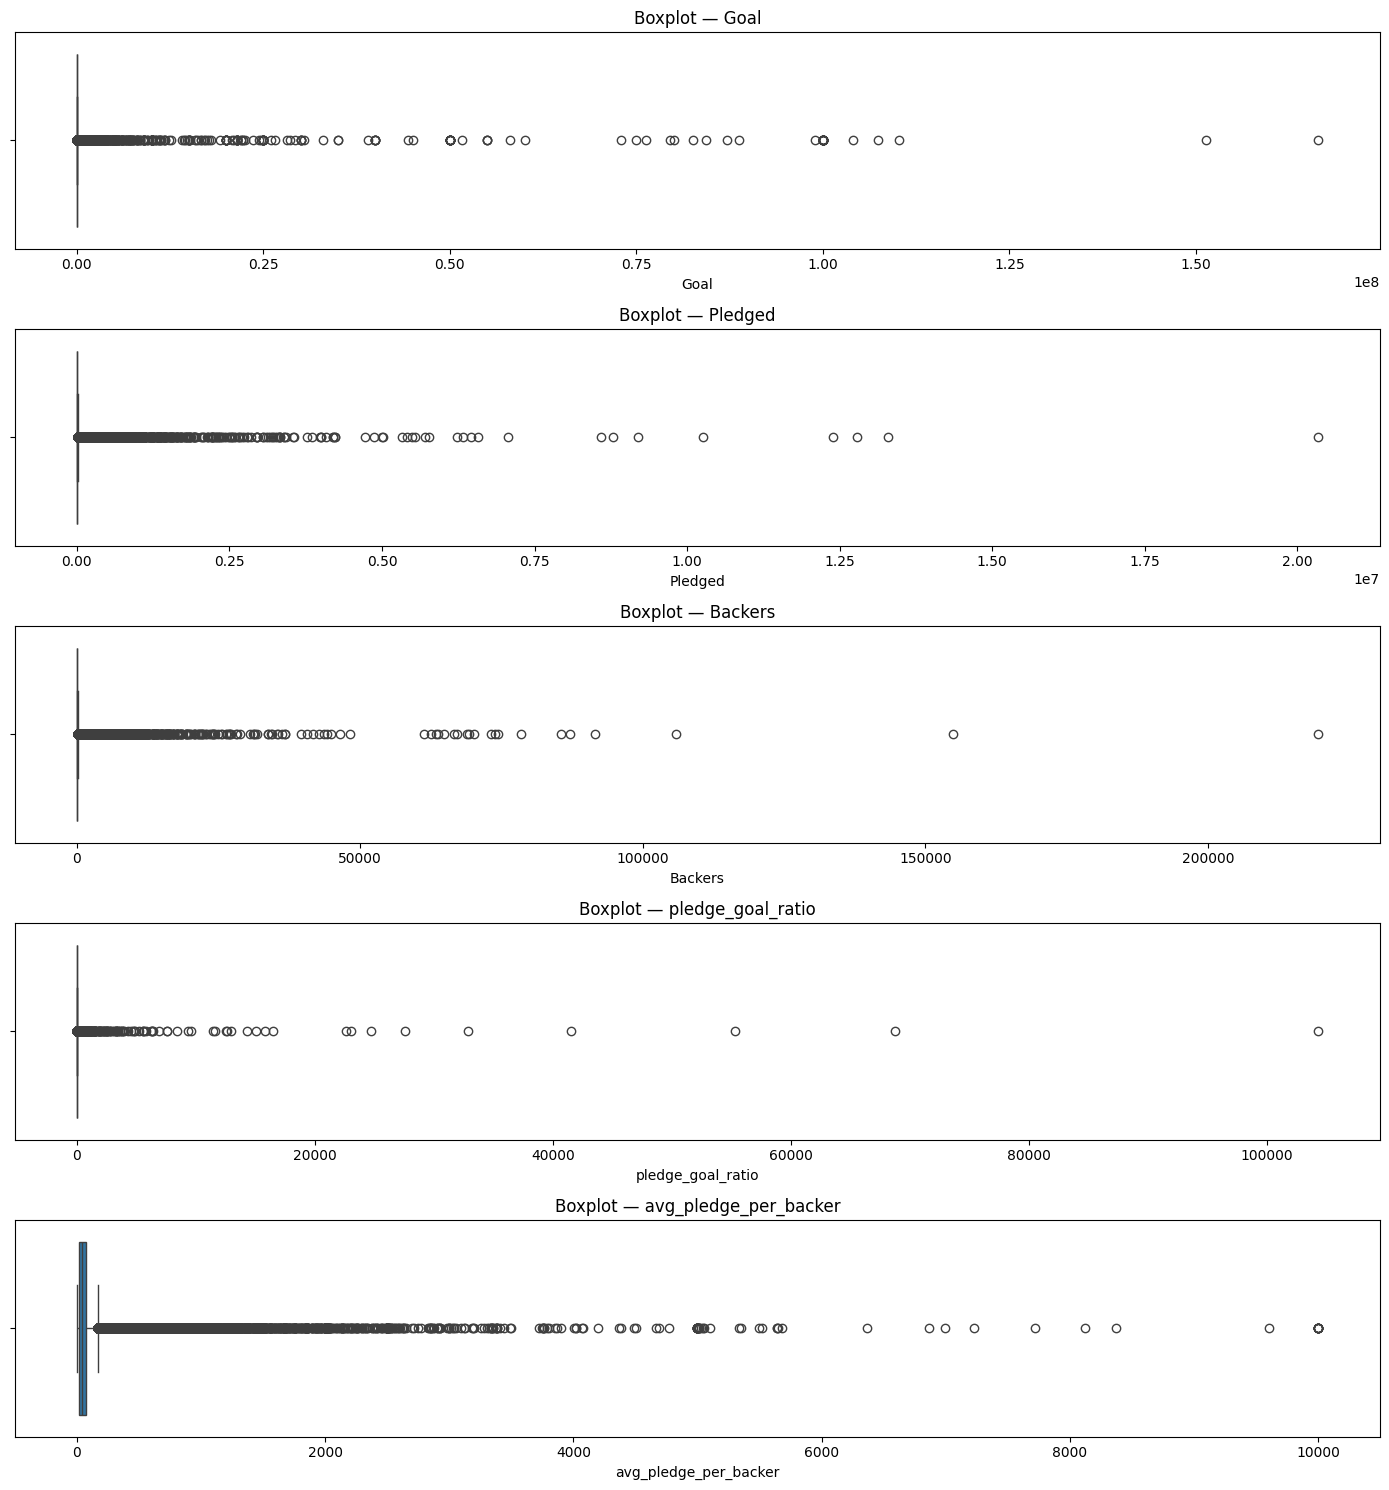

In [24]:
# pick high-variance / heavy-tailed columns if present
cand = ["Goal","Pledged","Backers","pledge_goal_ratio","avg_pledge_per_backer"]
show = [c for c in cand if c in Crowdfunding_df.columns]

plt.figure(figsize=(14, 3*len(show)))
for i, col in enumerate(show, 1):
    ax = plt.subplot(len(show), 1, i)
    sns.boxplot(x=Crowdfunding_df[col].dropna())
    ax.set_title(f"Boxplot — {col}")
plt.tight_layout(); plt.show()


### Distribution of Campaign States

C:\Users\tutul\AppData\Local\Temp\ipykernel_14672\99623474.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Crowdfunding_df, x="State", order=Crowdfunding_df["State"].value_counts().index, palette="viridis")


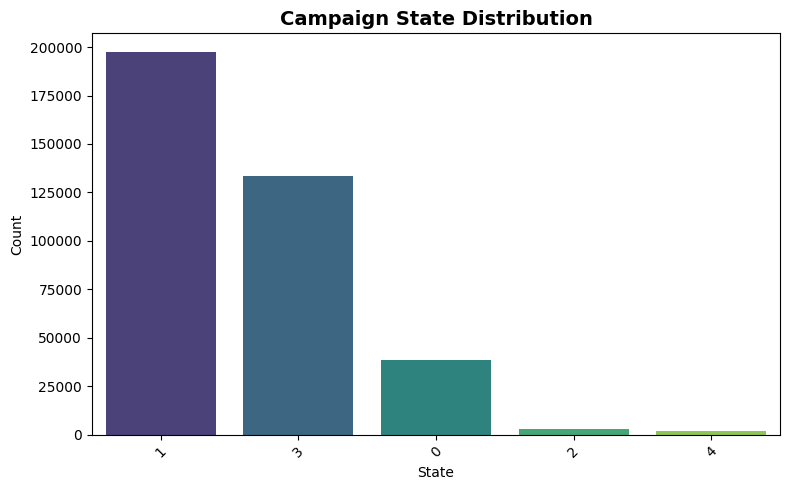

In [25]:
# State distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=Crowdfunding_df, x="State", order=Crowdfunding_df["State"].value_counts().index, palette="viridis")
plt.title("Campaign State Distribution", fontsize=14, fontweight="bold")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Distribution of Goals (Log Scale)

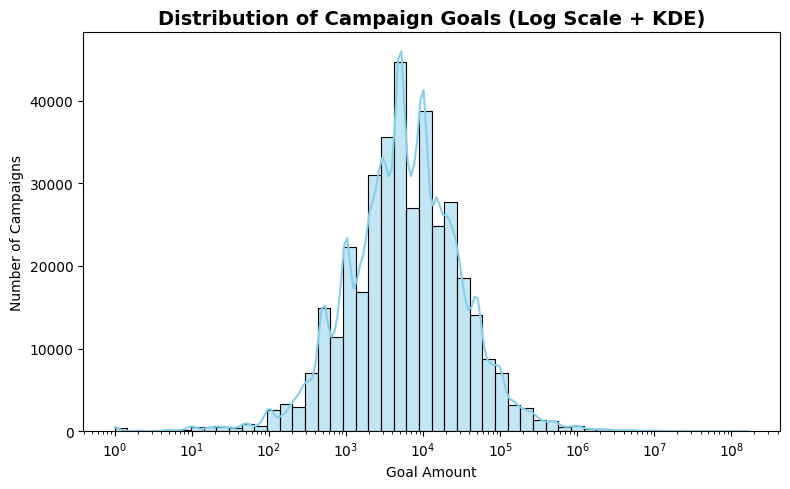

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(Crowdfunding_df["Goal"], bins=50, log_scale=(True, False), kde=True, color="skyblue")
plt.title("Distribution of Campaign Goals (Log Scale + KDE)", fontsize=14, fontweight="bold")
plt.xlabel("Goal Amount")
plt.ylabel("Number of Campaigns")
plt.tight_layout()
plt.show()


### Launch Month Seasonality

C:\Users\tutul\AppData\Local\Temp\ipykernel_14672\1566630420.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Crowdfunding_df, x="launch_month", palette="coolwarm")


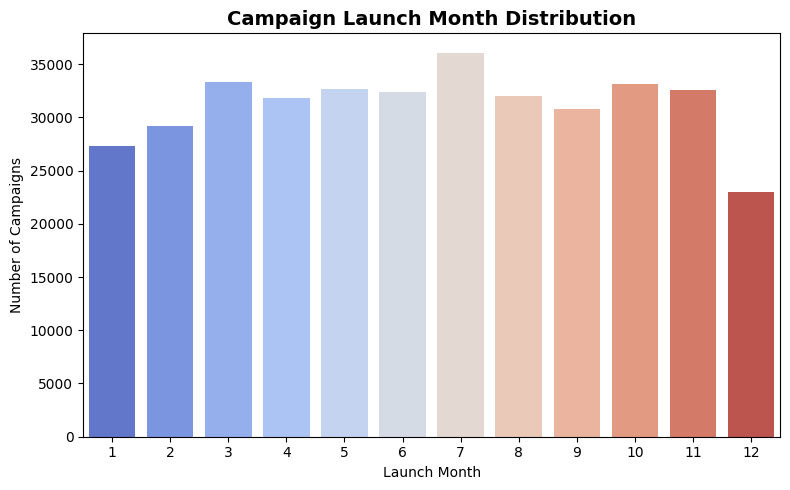

In [27]:
plt.figure(figsize=(8, 5))
sns.countplot(data=Crowdfunding_df, x="launch_month", palette="coolwarm")
plt.title("Campaign Launch Month Distribution", fontsize=14, fontweight="bold")
plt.xlabel("Launch Month")
plt.ylabel("Number of Campaigns")
plt.tight_layout()
plt.show()


### Correlation Heatmap


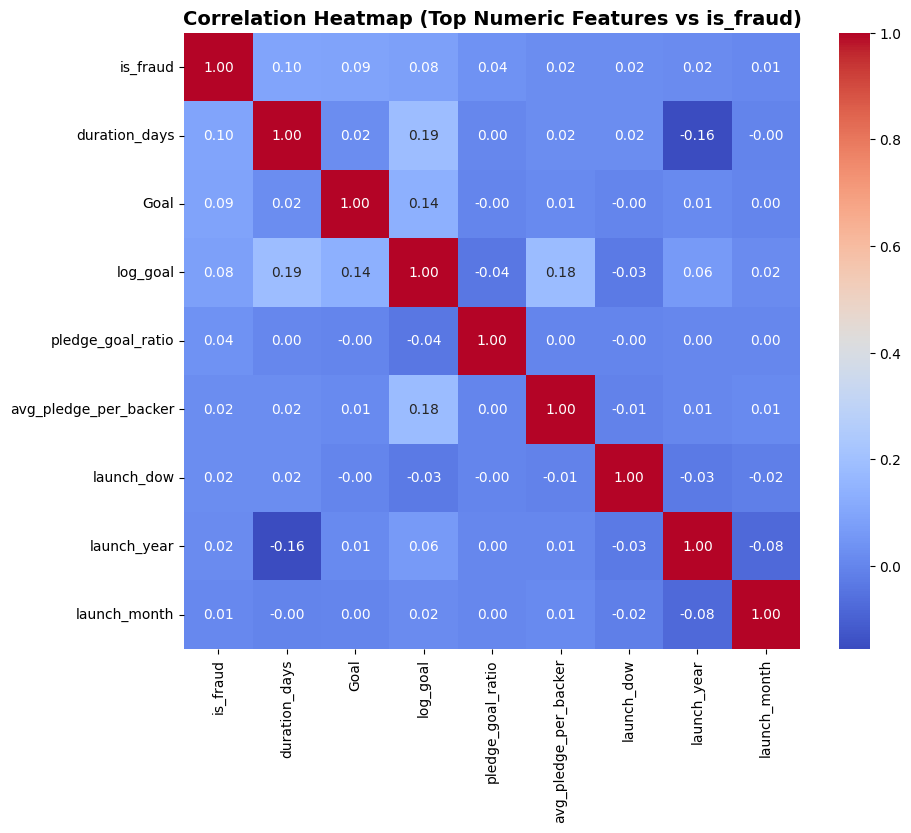

In [28]:
# Select important numerical features for correlation with is_flagged
important_num_features = [
    "Goal", "duration_days", "pledge_goal_ratio",
    "avg_pledge_per_backer", "log_goal", "launch_month",
    "launch_dow", "launch_year"
]

# Ensure 'is_flagged' exists
if 'is_fraud' in Crowdfunding_df.columns:
    important_num_features.append('is_fraud')

# Filter only existing columns
important_num_features = [f for f in important_num_features if f in Crowdfunding_df.columns]

# Compute correlation matrix
corr_matrix = Crowdfunding_df[important_num_features].corr(numeric_only=True)

# Sort by correlation with is_flagged
if 'is_fraud' in corr_matrix.columns:
    top_corr_features = corr_matrix['is_fraud'].abs().sort_values(ascending=False).head(10).index
else:
    top_corr_features = important_num_features

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(Crowdfunding_df[top_corr_features].corr(numeric_only=True),
            annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap (Top Numeric Features vs is_fraud)', fontsize=14, fontweight="bold")
plt.show()


In [29]:
Crowdfunding_df

,ID,Name,Category,Subcategory,Country,Launched,Deadline,Goal,Pledged,Backers,...,subcategory_freq,country_freq,launch_quarter,name_len_chars,name_len_words,name_upper_ratio,name_punct_count,anomaly_score_iforest,is_fraud,fraud_label
0,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,5,52,21,2009-04-21 21:02:48,2009-05-31,1000,625,30,...,0.022820,0.780621,2,59,10,0.169492,6,0.407562,0,Normal
1,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,6,129,21,2009-04-23 00:07:53,2009-07-20,80000,22,3,...,0.032965,0.780621,2,30,4,0.900000,0,0.652742,1,Fraud Suspected
2,1703704063,drawing for dollars,0,70,21,2009-04-24 21:52:03,2009-05-03,20,35,3,...,0.008470,0.780621,2,19,3,0.000000,0,0.458698,0,Normal
3,727286,Offline Wikipedia iPhone app,13,131,21,2009-04-25 17:36:21,2009-07-14,99,145,25,...,0.008126,0.780621,2,28,4,0.107143,0,0.413804,0,Normal
4,1622952265,Pantshirts,5,52,21,2009-04-27 14:10:39,2009-05-26,1900,387,10,...,0.022820,0.780621,2,10,1,0.100000,0,0.292649,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374848,1486845240,Americas Got Talent - Serious MAK,10,68,21,2018-01-02 14:13:09,2018-01-16,500,0,0,...,0.010433,0.780621,1,33,6,0.212121,1,0.513992,0,Normal
374849,974738310,EVO Planner: The World's First Personalized Fl...,4,113,21,2018-01-02 14:15:38,2018-02-09,15000,269,8,...,0.059517,0.780621,1,55,8,0.181818,2,0.246149,0,Normal
374850,2106246194,"Help save La Gattara, Arizona's first Cat Cafe!",7,58,21,2018-01-02 14:17:46,2018-01-16,10000,165,3,...,0.030657,0.780621,1,47,8,0.127660,3,0.217720,0,Normal
374851,1830173355,Digital Dagger Coin,0,10,21,2018-01-02 14:38:17,2018-02-01,650,7,1,...,0.022014,0.780621,1,19,3,0.157895,0,0.232510,0,Normal


### Fraud Label Distribution

C:\Users\tutul\AppData\Local\Temp\ipykernel_14672\440371423.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Crowdfunding_df, x="fraud_label", palette="Set2")


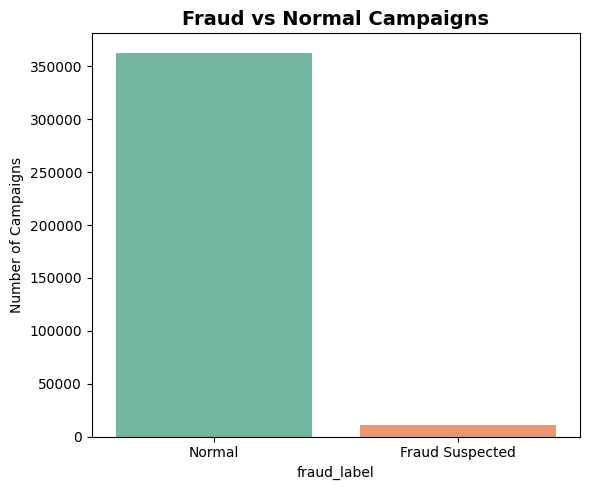

In [30]:
plt.figure(figsize=(6, 5))
sns.countplot(data=Crowdfunding_df, x="fraud_label", palette="Set2")
plt.title("Fraud vs Normal Campaigns", fontsize=14, fontweight="bold")
plt.ylabel("Number of Campaigns")
plt.tight_layout()
plt.show()


### KDE Plots for Fraud vs Normal

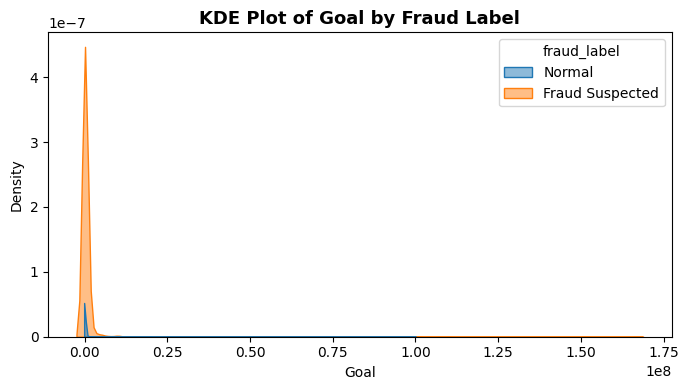

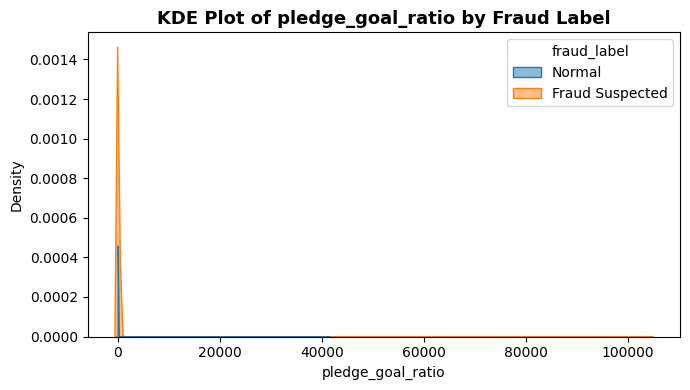

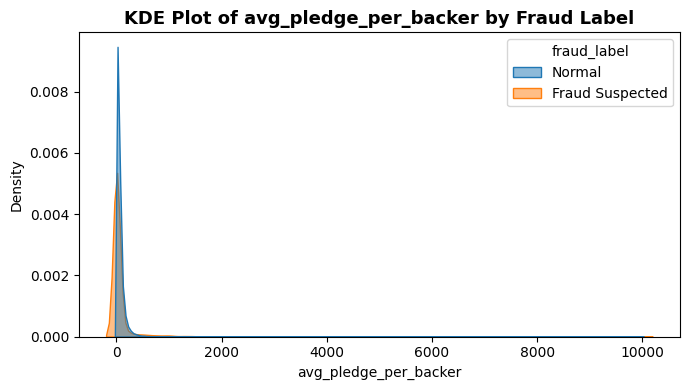

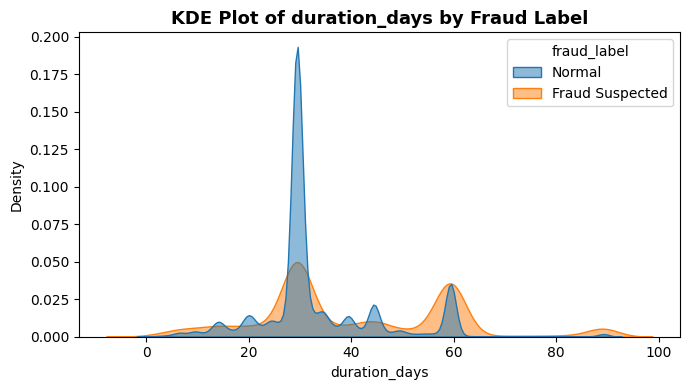

In [31]:
# KDE plots for Fraud Suspected vs Normal
selected_kde_features = [
    "Goal", "pledge_goal_ratio", "avg_pledge_per_backer", "duration_days"
]

for col in selected_kde_features:
    if col in Crowdfunding_df.columns:
        plt.figure(figsize=(7, 4))
        sns.kdeplot(data=Crowdfunding_df, x=col, hue="fraud_label", fill=True, common_norm=False, alpha=0.5)
        plt.title(f'KDE Plot of {col} by Fraud Label', fontsize=13, fontweight="bold")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.tight_layout()
        plt.show()


### Anomaly Score Distribution

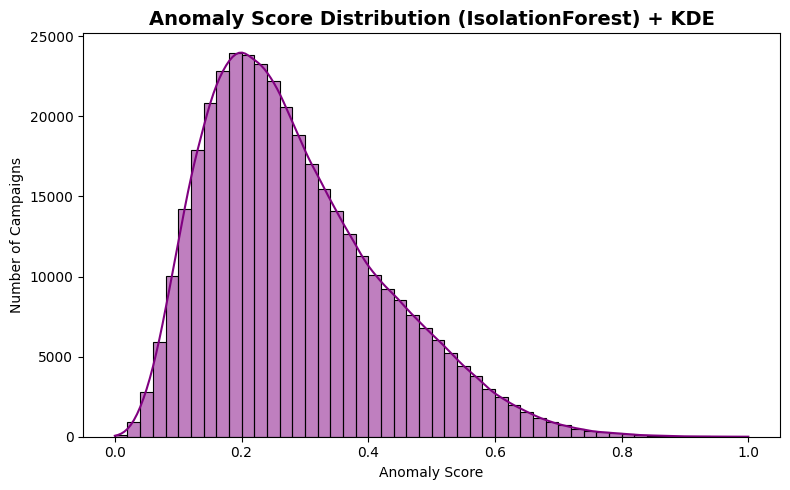

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(Crowdfunding_df["anomaly_score_iforest"], bins=50, kde=True, color="purple")
plt.title("Anomaly Score Distribution (IsolationForest) + KDE", fontsize=14, fontweight="bold")
plt.xlabel("Anomaly Score")
plt.ylabel("Number of Campaigns")
plt.tight_layout()
plt.show()


### Save the data

In [ ]:
# combined_df = Crowdfunding_df.copy()


# important_features = [
#     "Goal", "duration_days", "pledge_goal_ratio", "avg_pledge_per_backer",
#     "log_goal", "launch_month", "launch_dow", "launch_year", "launch_quarter",
#     "goal_bucket_code", "goal_decile",
#     "category_freq", "subcategory_freq", "country_freq",
#     "name_len_chars", "name_len_words", "name_upper_ratio", "name_punct_count",
#     "has_backers", "zero_pledge",
#     "is_fraud"
# ]

# reduced_df = Crowdfunding_df[important_features].copy()


### Save reduce data

In [ ]:
# reduced_df.to_csv('../data/reduced_df.csv', index=False)

### save comained_featuers_model_data


In [ ]:
# combined_df.to_csv('../data/combined_all_featuers_model_df.csv', index=False)